In [62]:
import json
from pathlib import Path
import pandas as pd

from src.utils.path_utils import get_models_dir

In [63]:
get_models_dir()

WindowsPath('C:/Users/erik/IES_codebase/EMG_Project/CDT406-Smart-Gripper/models')

In [64]:
LSTM_search_folder_path = str(get_models_dir()) + "/LSTM_search"
LSTM_STFT_search_folder_path = str(get_models_dir()) + "/LSTM_STFT_search"
LSTM_STFT_Dense_search_folder_path = str(get_models_dir()) + "/LSTM_STFT_Dense_search"

In [65]:
variant_folders = {
    1: "pre_processor_variant_1",
    2: "pre_processor_variant_2",
    3: "pre_processor_variant_3",
}

In [66]:
def load_best_trial_info(trial_folder: Path):
    """
    Given a folder for a single variant containing multiple trial folders,
    load all trial JSON files, find the best trial by val_f1_score, and return
    a dict of best hyperparameters and metric.
    """
    best_val_f1 = -float('inf')
    best_hp = None
    best_trial_id = None

    # Each trial saved in a folder named trial_xxx, usually containing trial.json or trial_summary.json
    for trial_subdir in trial_folder.glob("trial_*"):
        # Try to read a trial.json or trial_summary.json
        trial_json_path = None
        for candidate_name in ["trial.json", "trial_summary.json"]:
            candidate_path = trial_subdir / candidate_name
            if candidate_path.exists():
                trial_json_path = candidate_path
                break
        if trial_json_path is None:
            # no recognizable trial json
            continue

        with open(trial_json_path, 'r') as f:
            trial_data = json.load(f)

        # Extract val_f1_score metric from trial_data
        # Key depends on file format, try common locations
        metric = None
        if "metrics" in trial_data and "metrics" in trial_data:
            # Some formats store metric under 'metrics' -> 'metrics' (yes, duplicated sometimes)
            metrics_dict = trial_data.get("metrics", {})
            if "metrics" in metrics_dict and "val_f1_score" in metrics_dict["metrics"]:
                vals = metrics_dict["metrics"]["val_f1_score"]
                # val_f1_score is typically a dict with 'best' or 'observations'
                if isinstance(vals, dict) and "best" in vals:
                    metric = vals["best"]
                elif isinstance(vals, list) and len(vals) > 0:
                    metric = max(vals)
        # fallback simpler checks
        if metric is None:
            # Some store in trial_data["score"] or trial_data["best_val_f1_score"]
            metric = trial_data.get("best_val_f1_score", None)
        if metric is None:
            # Sometimes under trial_data['score']
            metric = trial_data.get("score", None)

        if metric is None:
            # Could not find metric, skip trial
            continue

        # Update best if improved
        if metric > best_val_f1:
            best_val_f1 = metric
            best_trial_id = trial_subdir.name
            # Extract hyperparameters - likely under trial_data['hyperparameters'] or 'hyperparameters'
            hp = trial_data.get("hyperparameters")
            if hp is None:
                # sometimes under other keys - print trial_data keys for debugging if needed
                hp = trial_data.get("values") or {}
            best_hp = hp

    return best_val_f1, best_hp, best_trial_id

In [67]:
def print_best_hyperparameters(trial_json: dict):
    """
    Given the loaded JSON dictionary from a trial file (with keys 'space' and 'values'),
    pretty print all hyperparameters and their chosen values in a nicely formatted way.
    """
    if "space" not in trial_json or "values" not in trial_json:
        print("Invalid hyperparameters JSON structure.")
        return

    space = trial_json["space"]
    values = trial_json["values"]

    print("Best Hyperparameters:\n")
    for hp_def in space:
        config = hp_def.get("config", {})
        name = config.get("name", "<unknown>")
        default = config.get("default")
        hp_type = hp_def.get("class_name", "<unknown>")

        # Extract the chosen value, use values dict
        chosen_value = values.get(name, None)

        # Prepare additional info string depending on hp_type
        additional_info = ""
        if hp_type == "Float":
            min_val = config.get("min_value")
            max_val = config.get("max_value")
            step = config.get("step")
            sampling = config.get("sampling")
            additional_info = f"(Float, range: {min_val} to {max_val}"
            if step is not None:
                additional_info += f", step: {step}"
            if sampling:
                additional_info += f", sampling: {sampling}"
            additional_info += ")"
        elif hp_type == "Choice":
            values_list = config.get("values", [])
            additional_info = f"(Choice, options: {values_list})"
        else:
            additional_info = f"({hp_type})"

        print(f"- {name}: {chosen_value} {additional_info}")

    print()

In [68]:
import matplotlib.pyplot as plt

def plot_f1_scores(results):
    """
    Given a list of result dicts, each containing at least
    'pre_processor_variant' and 'best_val_f1_score' keys,
    plot a bar chart of F1 scores for each variant.
    """
    variants = [res['pre_processor_variant'] for res in results]
    f1_scores = [res['best_val_f1_score'] for res in results]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(variants, f1_scores, color='skyblue')
    plt.xlabel("Preprocessor Variant")
    plt.ylabel("Best Validation F1 Score")

     # Use the name from the first result if present, else a default title
    plot_name = results[0].get('name') if results and 'name' in results[0] else None
    title = f"Best Validation F1 Score by Preprocessor Variant"
    if plot_name:
        title += f" — {plot_name}"
    plt.title(title)

    plt.ylim(0, max(f1_scores) * 1.1)
    plt.xticks(variants)

    # Annotate bars with the score
    for bar, score in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.01,
                 f"{score:.4f}", ha='center', va='bottom')

    plt.show()

In [69]:
def get_results(folder_path, variant_folders, name="None"):
    results = []

    for variant in variant_folders.items():
        print(f"\n=== Preprocessor variant {variant[0]} ===")

        # Load best trial info for this variant
        best_val_f1, best_hp, best_trial_id = load_best_trial_info(Path(folder_path + "/" + variant[1]))

        print(f"Best val_f1_score: {best_val_f1:.4f}")
        print(f"Best trial folder: {best_trial_id}")

        if best_hp is None:
            print("No hyperparameter data found.")
            continue

        # Use the pretty print function to display best hyperparameters
        print_best_hyperparameters(best_hp)

        # Store summary info for further processing if needed
        results.append({
            "pre_processor_variant": variant[0],
            "best_val_f1_score": best_val_f1,
            "best_trial_id": best_trial_id,
            "hyperparameters": best_hp,
            "name": name
        })



    return results


In [70]:
import matplotlib.pyplot as plt
import numpy as np


def plot_all_results_combined(results_list):
    """
    Given a list of results lists (each a list of dicts with keys:
    - 'pre_processor_variant'
    - 'best_val_f1_score'
    - 'name' (to color-code)

    Plot all results together in a single grouped bar plot,
    color-coded by 'name' with legend.

    This version uses only matplotlib (no seaborn).
    """
    # Flatten results and extract unique variants and names
    all_records = []
    names = []
    variants_set = set()
    for res_group in results_list:
        for res in res_group:
            all_records.append({
                'variant': str(res['pre_processor_variant']),
                'f1': res['best_val_f1_score'],
                'name': res.get('name', 'Unknown')
            })
            variants_set.add(str(res['pre_processor_variant']))
            if res.get('name') not in names:
                names.append(res.get('name', 'Unknown'))

    variants = sorted(variants_set, key=int)
    n_variants = len(variants)
    n_names = len(names)

    # Organize data into a matrix of shape (n_names, n_variants)
    # where rows are model names and columns are variants
    data_matrix = np.full((n_names, n_variants), np.nan)
    for rec in all_records:
        i = names.index(rec['name'])
        j = variants.index(rec['variant'])
        data_matrix[i, j] = rec['f1']

    # Plot parameters
    bar_width = 0.8 / n_names  # total width split among names
    x = np.arange(n_variants)  # x locations for groups

    # Choose distinct colors for each model name
    cmap = plt.get_cmap('tab10')
    colors = [cmap(i) for i in range(n_names)]

    plt.figure(figsize=(10, 6))

    for i in range(n_names):
        # Positions for each group member's bar
        bar_positions = x - 0.4 + i * bar_width + bar_width / 2
        plt.bar(bar_positions, data_matrix[i], width=bar_width,
                color=colors[i], label=names[i])

        # Annotate bars with actual values, skip NaNs
        for xpos, val in zip(bar_positions, data_matrix[i]):
            if not np.isnan(val):
                plt.text(xpos, val * 1.01, f'{val:.4f}',
                         ha='center', va='bottom', fontsize=9)

    plt.xlabel("Preprocessor Variant")
    plt.ylabel("Best Validation F1 Score")
    plt.title("Best Validation F1 Score by Preprocessor Variant and Model Type")
    plt.xticks(x, variants)
    plt.ylim(0, np.nanmax(data_matrix) * 1.1)
    plt.legend(title="Model Name")
    plt.tight_layout()
    plt.show()

# LSTM Result

In [71]:
LSTM_results = get_results(LSTM_search_folder_path, variant_folders, name="LSTM")


=== Preprocessor variant 1 ===
Best val_f1_score: 0.6340
Best trial folder: trial_07
Best Hyperparameters:

- learning_rate: 0.0029509378809237773 (Float, range: 1e-06 to 0.005, sampling: log)
- optimizer: adam (Choice, options: ['adam', 'rmsprop', 'nadam'])
- normalization: none (Choice, options: ['none', 'batch', 'layer'])
- dropout: 0.0 (Float, range: 0.0 to 0.5, step: 0.1, sampling: linear)
- recurrent_dropout: 0.30000000000000004 (Float, range: 0.0 to 0.5, step: 0.1, sampling: linear)
- act_dense: relu (Choice, options: ['tanh', 'relu'])
- act_lstm: tanh (Choice, options: ['tanh', 'relu'])
- batch_size: 64 (Choice, options: [32, 64, 128, 256, 512])


=== Preprocessor variant 2 ===
Best val_f1_score: 0.6438
Best trial folder: trial_09
Best Hyperparameters:

- learning_rate: 0.001016713721415275 (Float, range: 1e-06 to 0.005, sampling: log)
- optimizer: rmsprop (Choice, options: ['adam', 'rmsprop', 'nadam'])
- normalization: layer (Choice, options: ['none', 'batch', 'layer'])
- dro

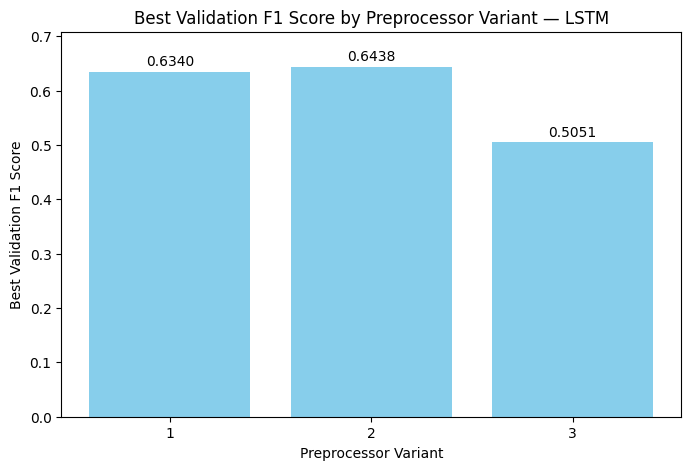

In [72]:
plot_f1_scores(LSTM_results)

# LSTM STFT Result

In [73]:
LSTM_STFT_results = get_results(LSTM_STFT_search_folder_path, variant_folders, name="LSTM STFT")


=== Preprocessor variant 1 ===
Best val_f1_score: 0.6342
Best trial folder: trial_04
Best Hyperparameters:

- learning_rate: 0.0004649555698588222 (Float, range: 1e-06 to 0.005, sampling: log)
- optimizer: rmsprop (Choice, options: ['adam', 'rmsprop', 'nadam'])
- normalization: batch (Choice, options: ['none', 'batch', 'layer'])
- dropout: 0.0 (Float, range: 0.0 to 0.5, step: 0.1, sampling: linear)
- recurrent_dropout: 0.1 (Float, range: 0.0 to 0.5, step: 0.1, sampling: linear)
- act_dense: tanh (Choice, options: ['tanh', 'relu'])
- act_lstm: tanh (Choice, options: ['tanh', 'relu'])
- stft_frame_length: 81 (Int)
- stft_frame_step: 30 (Int)
- batch_size: 256 (Choice, options: [32, 64, 128, 256, 512])


=== Preprocessor variant 2 ===
Best val_f1_score: 0.6129
Best trial folder: trial_06
Best Hyperparameters:

- learning_rate: 4.601994026207251e-05 (Float, range: 1e-06 to 0.005, sampling: log)
- optimizer: rmsprop (Choice, options: ['adam', 'rmsprop', 'nadam'])
- normalization: layer (Ch

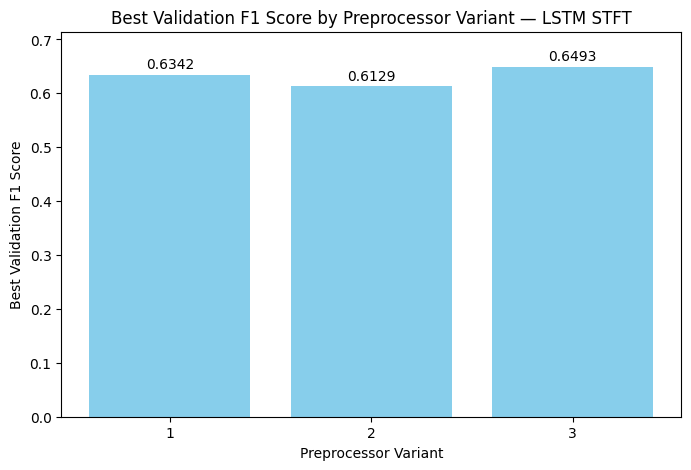

In [74]:
plot_f1_scores(LSTM_STFT_results)

# LSTM STFT Dense Result

In [75]:
LSTM_STFT_Dense_results = get_results(LSTM_STFT_Dense_search_folder_path, variant_folders, name="LSTM STFT Dense")


=== Preprocessor variant 1 ===
Best val_f1_score: 0.6206
Best trial folder: trial_03
Best Hyperparameters:

- learning_rate: 0.00029130807481784213 (Float, range: 1e-06 to 0.005, sampling: log)
- optimizer: nadam (Choice, options: ['adam', 'rmsprop', 'nadam'])
- normalization: batch (Choice, options: ['none', 'batch', 'layer'])
- dropout: 0.1 (Float, range: 0.0 to 0.5, step: 0.1, sampling: linear)
- recurrent_dropout: 0.2 (Float, range: 0.0 to 0.5, step: 0.1, sampling: linear)
- act_dense: tanh (Choice, options: ['tanh', 'relu'])
- act_lstm: relu (Choice, options: ['tanh', 'relu'])
- stft_frame_length: 81 (Int)
- stft_frame_step: 14 (Int)
- batch_size: 64 (Choice, options: [32, 64, 128, 256, 512])


=== Preprocessor variant 2 ===
Best val_f1_score: 0.6461
Best trial folder: trial_11
Best Hyperparameters:

- learning_rate: 0.0007704428677376002 (Float, range: 1e-06 to 0.005, sampling: log)
- optimizer: nadam (Choice, options: ['adam', 'rmsprop', 'nadam'])
- normalization: layer (Choice

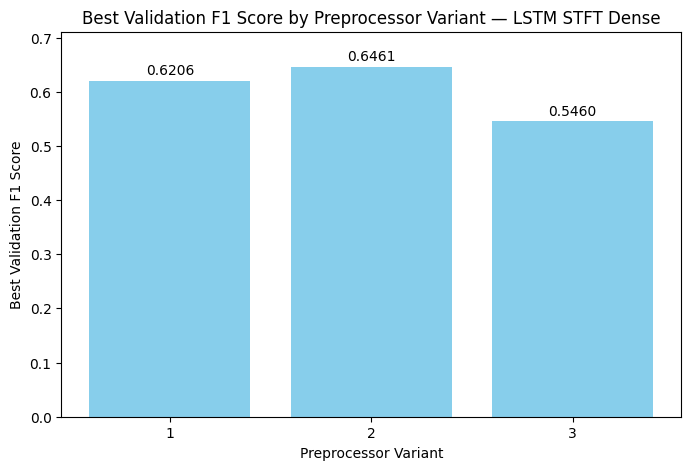

In [76]:
plot_f1_scores(LSTM_STFT_Dense_results)

# Total Results

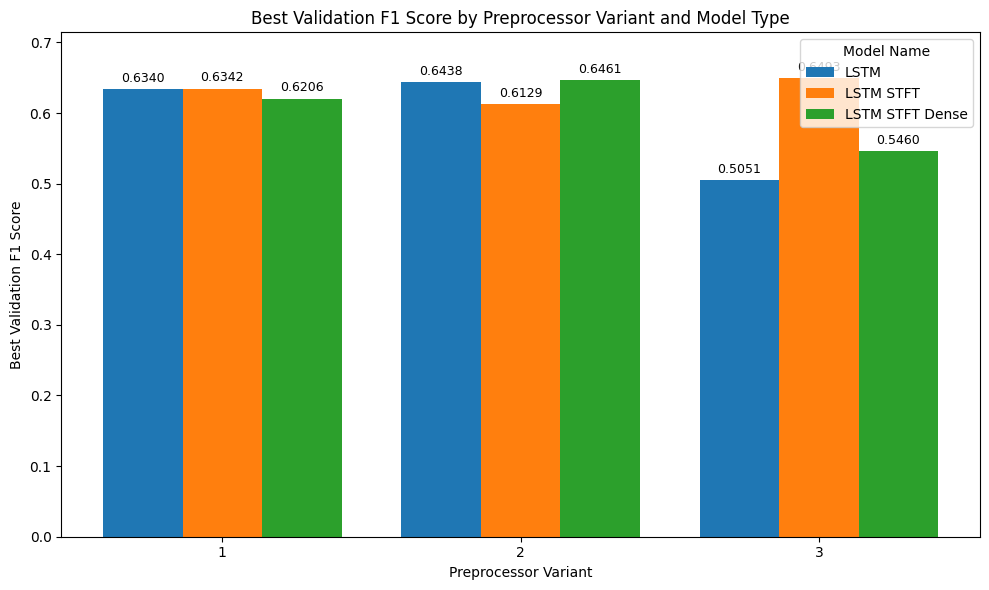

In [78]:
plot_all_results_combined([LSTM_results, LSTM_STFT_results, LSTM_STFT_Dense_results])